In [123]:
import ee 
import shapely as shp
import pandas as pd
import numpy as np
import geopandas as gpd
import ast
from shapely.geometry import Polygon, MultiPolygon, Point
import rasterio
import geopandas as gpd
import sys
%load_ext autoreload
%autoreload 2
sys.path.insert(1, '/Users/gr_1/Documents/simplem/')
import simplem_par as simplem
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [151]:
folder = 'r_mn0'
ns = np.load('{}/ns.npy'.format(folder),allow_pickle=True)
ms = np.load('{}/ms.npy'.format(folder),allow_pickle=True)
diffus = np.load('{}/diffu.npy'.format(folder),allow_pickle=True)
Gs = np.load('{}/Gs.npy'.format(folder),allow_pickle=True)
eros1 = np.load('{}/eros.npy'.format(folder),allow_pickle=True)
ks = np.load('{}/ks.npy'.format(folder),allow_pickle=True)
careas = np.load('{}/careas.npy'.format(folder),allow_pickle=True)

In [152]:
#@jit(nopython=True)
#def loop_results(eros1, dfs,n,c):
n = 3553
nt = 1000
dfs = np.array([None]*len(eros1[1]))
              
c=0
for i in range(len(eros1[1])):
        dfs[i] = np.zeros(len(eros1))
        for k in range(1,len(eros1)):
            if (eros1[k] is None):
                continue
            else:
                dfs[i][k] = eros1[k][i]
            c+=1
    #return dfs
dfs_d = dfs.copy()

In [153]:
folder = 'r_mn05_1'
ns = np.load('{}/ns.npy'.format(folder),allow_pickle=True)
ms = np.load('{}/ms.npy'.format(folder),allow_pickle=True)
diffus = np.load('{}/diffu.npy'.format(folder),allow_pickle=True)
Gs = np.load('{}/Gs.npy'.format(folder),allow_pickle=True)
eros1 = np.load('{}/eros.npy'.format(folder),allow_pickle=True)
ks = np.load('{}/ks.npy'.format(folder),allow_pickle=True)
careas = np.load('{}/careas.npy'.format(folder),allow_pickle=True)

In [154]:
#@jit(nopython=True)
#def loop_results(eros1, dfs,n,c):
n = 3553
nt = 1000
dfs = np.array([None]*len(eros1[1]))
drat = np.array([None]*len(eros1[1]))
            
c=0
for i in range(len(eros1[1])):
        dfs[i] = np.zeros(len(eros1))
        drat[i] = np.zeros(len(eros1))

        for k in range(1,len(eros1)):
            if (eros1[k] is None):
                continue
            else:
                dfs[i][k] = eros1[k][i] - dfs_d[0][k]* diffus[i] / .01
                #dfs[i][k] = dfs[i][k] + dfs_d[0][k]*200
                drat[i][k] = (dfs_d[0][k]* diffus[i] / .01)/eros1[k][i] 
            c+=1
    #return dfs


<ipython-input-154-307cabf4ed07>:19: RuntimeWarning: invalid value encountered in double_scalars
  drat[i][k] = (dfs_d[0][k]* diffus[i] / .01)/eros1[k][i]


In [133]:
a = gpd.read_file('/Users/gr_1/Documents/cosmo_predict/octo_327_data')

In [272]:
from sklearn import linear_model as lm
import sklearn
r2s = np.zeros(len(eros1[1]))
resid = np.zeros(len(eros1[1]))
pcoef = np.zeros(len(eros1[1]))
dratave = np.zeros(len(eros1[1]))

ks2 = ns.copy()#ks.copy()
diffus2 = diffus.copy()
for i in range(len(eros1[1])):#range(len(ms)):
        if dfs[i] is None:
            continue
        
        y = np.log(np.float64(a['ebe_mmkyr'])/1000)
        x = np.log(dfs[i][:len(a)])
        #I_min = np.where(a['slp_ave'][:n]/1000>1e-1)[0]
        #x=x[I_min]
        #y=y[I_min]
        xi = x.copy()
        I = np.where(np.logical_or(np.isnan(x),np.isinf(x)))[0]
        x=np.delete(x,I)
        y=np.delete(y,I)
        I2 = np.where(np.logical_or(np.isnan(y),np.isnan(x)))[0]
        x = np.delete(x,I2)
        y = np.delete(y,I2)
        l1  = lm.LinearRegression(fit_intercept=False)
        l = lm.LinearRegression(fit_intercept=False)
        if len(x[np.logical_not(np.isnan(x))])>n-3500:
                print(len(x[np.logical_not(np.isnan(x))]))
                
                p1 = l1.fit(np.exp(x.reshape(-1,1)),np.exp(y.reshape(-1,1)))
                p = l.fit(x.reshape(-1,1), y.reshape(-1,1 ))

                intercept =np.mean(y-x)
                y2 = x+intercept
                #y2 = p.predict(x.reshape(-1,1))
                y3 = np.exp(x) * p1.coef_#p1.predict(np.exp(x.reshape(-1,1)))
                try:
                    r2s[i] = sklearn.metrics.r2_score(y.reshape(-1,1),y2)

                except:
                    print('here')
                diffus2[i] *= p1.coef_
                ks2[i] *= p1.coef_
                resid[i] = -np.sum(np.power(y.ravel()-np.log(y3.ravel()),2))
                print(len(y[np.logical_not(np.isnan(x))]))
                pcoef[i] = intercept#p1.intercept_
                dratave[i] = np.mean(drat[i][drat[i]>0])
               # if resid[i]>127.9:
                #    break
a['maxr2'] = dfs[np.argmax(r2s)][:len(a)]

<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: invalid value encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: invalid value encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: invalid value encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: invalid value encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero 

2515
2515
3087
3087
3182
3182
2476
2476
3035
3035
2641
2641
2694
2694
3145
3145
2318
2318
3147
3147
2612
2612
3028
3028
3169
3169
2991
2991
2281
2281
3145
3145
2745
2745
2474
2474
3171
3171
2993
2993
2420
2420
3007
3007
3062
3062
2912
2912
3176
3176
2711
2711
3147
3147
3168
3168
2725
2725
2945
2945
3014
3014
2878
2878
3134
3134
2391
2391
3170
3170
2700
2700
2812
2812
3152
3152
2291
2291
3026
3026
3113
3113
2769
2769
2934
2934
3167
3167
2693
2693
2846
2846
3162
3162
2827
2827
3189
3189
2910
2910
2405
2405
3166
3166
2793
2793
3182
3182
3175
3175
3178
3178
3156
3156
3164
3164
3177
3177
2888
2888
2913
2913
2786
2786
2667
2667
2634
2634
3182
3182
3132
3132
3171
3171
3172
3172
3121
3121
2567
2567
3084
3084
3067
3067
3142
3142
2875
2875
2637
2637
3163
3163
2743
2743
2609
2609
3135
3135
2851
2851
2553
2553
2545
2545
3105
3105
2593
2593
2937
2937
2614
2614
3181
3181
2824
2824
3071
3071
3170
3170
3109
3109
3157
3157
3166
3166
3165
3165
2308
2308
2409
2409
3043
3043
3189
3189
3135
3135
3169
3169


<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: invalid value encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: invalid value encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: invalid value encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: invalid value encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero 

3061
3061
3102
3102
3184
3184
2723
2723
2920
2920
3171
3171
3163
3163
3144
3144
2707
2707
2993
2993
3168
3168
3005
3005
2503
2503
2394
2394
2680
2680
2642
2642
3153
3153
2951
2951
2745
2745
2387
2387
3180
3180
2307
2307
2848
2848
2567
2567
2971
2971
2803
2803
2290
2290
3179
3179
3063
3063
3107
3107
2669
2669
2847
2847
2886
2886
3169
3169
2786
2786
2704
2704
2871
2871
2852
2852
2492
2492
2302
2302
2682
2682
3162
3162
2848
2848
2761
2761
3024
3024
2944
2944
3180
3180
3110
3110
3174
3174
2512
2512
3176
3176
3082
3082
3155
3155
3128
3128
3165
3165
3076
3076
2584
2584
3170
3170
3086
3086
2825
2825
3181
3181
3025
3025
2929
2929
3181
3181
2751
2751
3156
3156
2631
2631
3143
3143
2365
2365
2597
2597
2627
2627
3143
3143
3166
3166
2517
2517
2640
2640
3164
3164
2430
2430
3166
3166
3134
3134
3144
3144
2942
2942
3135
3135
2655
2655
2982
2982
2583
2583
2924
2924
2859
2859
3055
3055
2936
2936
3033
3033
2931
2931
3092
3092
2603
2603
3148
3148
3156
3156
2976
2976
3111
3111
3008
3008
2293
2293
3084
3084


<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: invalid value encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: invalid value encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: invalid value encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: invalid value encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero 

2964
2685
2685
2822
2822
3150
3150
3128
3128
3153
3153
2338
2338
2784
2784
3016
3016
2374
2374
3173
3173
2648
2648
3071
3071
2993
2993
3078
3078
3166
3166
3186
3186
2988
2988
3153
3153
3107
3107
2813
2813
2345
2345
3046
3046
3183
3183
3115
3115
2504
2504
2699
2699
2591
2591
2622
2622
3066
3066
3169
3169
3105
3105
2298
2298
2950
2950
3168
3168
2707
2707
2437
2437
2929
2929
2699
2699
3123
3123
2908
2908
2687
2687
2899
2899
3124
3124
2990
2990
2999
2999
3189
3189
2917
2917
3091
3091
3003
3003
3154
3154
2373
2373
3165
3165
2711
2711
3070
3070
2330
2330
2691
2691
3157
3157
3164
3164
2863
2863
2959
2959
2670
2670
2585
2585
2271
2271
2650
2650
3126
3126
3119
3119
3128
3128
2485
2485
3182
3182
2859
2859
2789
2789
2853
2853
2321
2321
3150
3150
3115
3115
3139
3139
3163
3163
2733
2733
2512
2512
2704
2704
3181
3181
3117
3117
3189
3189
2369
2369
2358
2358
2708
2708
2591
2591
3058
3058
2902
2902
3067
3067
2964
2964
3037
3037
2363
2363
2743
2743
2352
2352
3180
3180
3116
3116
3048
3048
2923
2923
3100


<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: invalid value encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: invalid value encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: invalid value encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: invalid value encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero 

2749
2749
2936
2936
3139
3139
2510
2510
2860
2860
2724
2724
3123
3123
3171
3171
3050
3050
2929
2929
2896
2896
3104
3104
2911
2911
2762
2762
3171
3171
2395
2395
2843
2843
2803
2803
2760
2760
2945
2945
3175
3175
2515
2515
2500
2500
2776
2776
3091
3091
3169
3169
3172
3172
2824
2824
3138
3138
2729
2729
3051
3051
2619
2619
3181
3181
2395
2395
3094
3094
2469
2469
2536
2536
2882
2882
3163
3163
2887
2887
3170
3170
3164
3164
2816
2816
2774
2774
2301
2301
2476
2476
2950
2950
3174
3174
2676
2676
3162
3162
2885
2885
2928
2928
2883
2883
2598
2598
3065
3065
3174
3174
3188
3188
3006
3006
3094
3094
2615
2615
3179
3179
2429
2429
2932
2932
3189
3189
3138
3138
2292
2292
2672
2672
3159
3159
2535
2535
3151
3151
3094
3094
3176
3176
2426
2426
2784
2784
2925
2925
3185
3185
2707
2707
3054
3054
2727
2727
3169
3169
2795
2795
2875
2875
3188
3188
3145
3145
2764
2764
3122
3122
2549
2549
3164
3164
3031
3031
3166
3166
2554
2554
3013
3013
2668
2668
3175
3175
3053
3053
2278
2278
2592
2592
2310
2310
2674
2674
2728
2728


<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: invalid value encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: invalid value encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: invalid value encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: invalid value encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero 

3190
2999
2999
3172
3172
2700
2700
3024
3024
3098
3098
2843
2843
2723
2723
3021
3021
2887
2887
3146
3146
3049
3049
2663
2663
2988
2988
2478
2478
2997
2997
3120
3120
2700
2700
2830
2830
3184
3184
3179
3179
3012
3012
2318
2318
2941
2941
2928
2928
3168
3168
2802
2802
3147
3147
3170
3170
3175
3175
3086
3086
2675
2675
3006
3006
3167
3167
3181
3181
2963
2963
2990
2990
2506
2506
2859
2859
3149
3149
3099
3099
2288
2288
3187
3187
2384
2384
3060
3060
2846
2846
3105
3105
2915
2915
2748
2748
2631
2631
2984
2984
2969
2969
3092
3092
3098
3098
2840
2840
2991
2991
3032
3032
2758
2758
2641
2641
3084
3084
2765
2765
2489
2489
2713
2713
3167
3167
2898
2898
3056
3056
2595
2595
2702
2702
2673
2673
2609
2609
2979
2979
2932
2932
2579
2579
2856
2856
3002
3002
3114
3114
3022
3022
2984
2984
3169
3169
3139
3139
2834
2834
2859
2859
3017
3017
3165
3165
2630
2630
2776


<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: invalid value encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: invalid value encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: invalid value encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: invalid value encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero 

2776
3168
3168
3155
3155
3141
3141
3093
3093
2825
2825
3163
3163
2983
2983
2624
2624
2652
2652
3130
3130
2664
2664
3038
3038
3127
3127
2756
2756
3010
3010
3141
3141
2305
2305
3144
3144
2784
2784
3165
3165
3026
3026
2749
2749
3123
3123
2662
2662
2384
2384
3162
3162
2543
2543
2853
2853
2696
2696
3006
3006
3116
3116
2727
2727
3141
3141
2300
2300
2370
2370
3160
3160
3179
3179
3159
3159
3061
3061
3072
3072
3132
3132
2839
2839
3102
3102
3094
3094
2696
2696
2447
2447
2997
2997
2636
2636
3153
3153
2310
2310
3043
3043
2855
2855
2769
2769
2909
2909
3087
3087
3126
3126
2722
2722
2654
2654
3172
3172
3069
3069
2390
2390
3164
3164
3033
3033
2284
2284
2830
2830
2667
2667
2811
2811
3135
3135
3180
3180
3031
3031
3172
3172
3031
3031
2769
2769
3175
3175
2565
2565
2761
2761
3183
3183
3042
3042
3115
3115
3176
3176
2910
2910
3025
3025
3182
3182
3160
3160
3106
3106
2311
2311
2886
2886
2711
2711
2811
2811
2930
2930
2593
2593
3173
3173
3090
3090
3123
3123
3049
3049
2713
2713
3171
3171
2513
2513


<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: invalid value encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: invalid value encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: invalid value encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: invalid value encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero 

2832
2832
3169
3169
2583
2583
3067
3067
3122
3122
3056
3056
2582
2582
2934
2934
3173
3173
2614
2614
3012
3012
2951
2951
2621
2621
2928
2928
2710
2710
3086
3086
3031
3031
3141
3141
2356
2356
2854
2854
2781
2781
2602
2602
3171
3171
2440
2440
3174
3174
3171
3171
3170
3170
2339
2339
3175
3175
2721
2721
3164
3164
3130
3130
3002
3002
3028
3028
2487
2487
2817
2817
2828
2828
2659
2659
2768
2768
3126
3126
2903
2903
3136
3136
3184
3184
2368
2368
2637
2637
3166
3166
2688
2688
3086
3086
3172
3172
3175
3175
2715
2715
3018
3018
2294
2294
3024
3024
3129
3129
3038
3038
3023
3023
2600
2600
2749
2749
3174
3174
3177
3177
3173
3173
3167
3167
3166
3166
3183
3183
3171
3171
3164
3164
3171
3171
2575
2575
2671
2671
3090
3090
2408
2408
2876
2876
3061
3061
3150
3150
2594
2594
3133
3133
3138
3138
3140
3140
2496
2496
2690
2690
2661
2661
2689
2689
3191
3191
3183
3183
3013
3013
2934
2934
3164
3164
2650


<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: invalid value encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: invalid value encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: invalid value encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: invalid value encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero 

2650
2670
2670
3121
3121
3162
3162
2355
2355
2319
2319
3166
3166
2574
2574
2729
2729
3036
3036
3171
3171
3154
3154
2561
2561
3100
3100
3172
3172
3007
3007
3024
3024
3173
3173
2987
2987
3150
3150
3142
3142
2922
2922
3060
3060
2650
2650
2643
2643
3055
3055
2362
2362
2660
2660
3147
3147
2757
2757
2771
2771
3168
3168
3070
3070
3096
3096
3093
3093
2668
2668
2391
2391
2617
2617
2645
2645
3171
3171
3131
3131
2333
2333
3176
3176
3190
3190
3173
3173
2365
2365
3158
3158
2852
2852
2337
2337
2675
2675
3139
3139
3189
3189
2617
2617
2635
2635
2314
2314
2866
2866
3157
3157
3045
3045
2703
2703
2915
2915
3125
3125
2681
2681
3144
3144
3190
3190
3122
3122
3114
3114
2810
2810
3062
3062
3181
3181
2736
2736
3175
3175
2753
2753
3108
3108
2623
2623
2565
2565
2648
2648
3013
3013
3172
3172
2785
2785
3120
3120
2350
2350
3095
3095
2460


<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: invalid value encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: invalid value encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: invalid value encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: invalid value encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero 

2460
3119
3119
2359
2359
3166
3166
2985
2985
2805
2805
3178
3178
3166
3166
2750
2750
3038
3038
2308
2308
3171
3171
2368
2368
2353
2353
2790
2790
3189
3189
3131
3131
3186
3186
2522
2522
2978
2978
3098
3098
3103
3103
3125
3125
3026
3026
2974
2974
2941
2941
3126
3126
2334
2334
3162
3162
2589
2589
3189
3189
2951
2951
3155
3155
2727
2727
3153
3153
2828
2828
2505
2505
2622
2622
2885
2885
3149
3149
2986
2986


<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: invalid value encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: invalid value encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: invalid value encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: invalid value encountered in log
  x = np.log(dfs[i][:len(a)])
<ipython-input-272-c71f96baa5a7>:15: RuntimeWarning: divide by zero 

(0.035, 0.1)

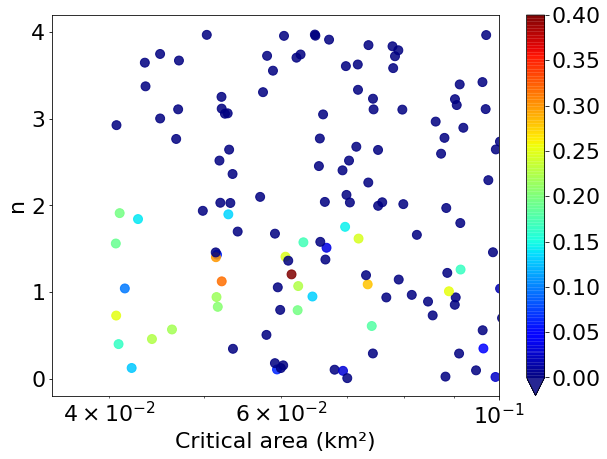

In [273]:
plt.rcParams.update({'font.size': 22})
superscript = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")
fig, ax = plt.subplots(figsize = (10,7))
ax = plt.scatter(careas*90**2/1e6,ns,c=r2s,s=80, vmin=0, vmax=.4, cmap = 'jet',alpha=.85)
plt.xscale('log')
plt.xlabel('Critical area (km' +'2'.translate(superscript)+')')
plt.colorbar(ax,extend = 'min')
plt.ylabel('n')
plt.xlim([3.5*10**-2, 10**-1])
#plt.ylim([-1,.5])

In [ ]:
plt.rcParams.update({'font.size': 22})
superscript = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")
fig, ax = plt.subplots(figsize = (10,7))
plt.plot(ns,r2s,'.k',markersize=15)
#plt.xscale('log')
plt.ylim([-1, .5])
#plt.xlim([10**.6, 10**1.3])
plt.ylabel('r' +'2'.translate(superscript))
#plt.xlabel('Critical area (km' +'2'.translate(superscript)+')')
plt.xlabel('n')


Text(0, 0.5, 'r²')

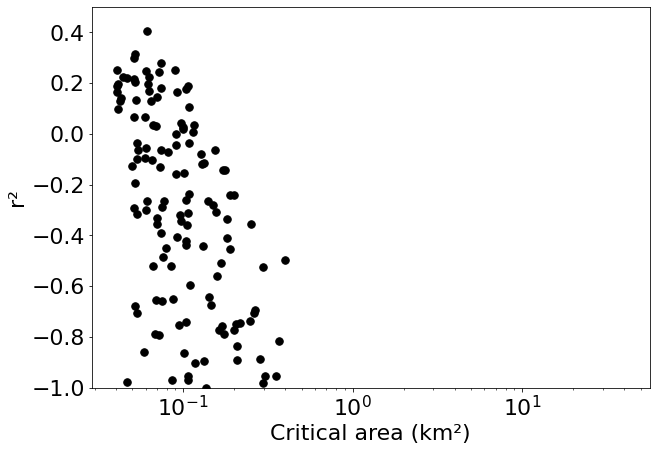

In [285]:
plt.rcParams.update({'font.size': 22})
superscript = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")
fig, ax = plt.subplots(figsize = (10,7))
plt.plot(careas*90**2/1e6,r2s,'.k',markersize=15)
plt.xscale('log')
plt.ylim([-1, .5])
#plt.xlim([10**.6, 10**1.3])
plt.xlabel('Critical area (km' +'2'.translate(superscript)+')')
plt.ylabel('r' + '2'.translate(superscript))


In [100]:
import rasterio as rio

In [121]:
f = rio.open('/Users/gr_1/Downloads/133023_06_1(1)/2019_B7_DGIR_v2.ers')
profile = f.profile
profile['driver'] = "GTiff"
array = f.read()
with rasterio.open('gravity_resid.tif', 'w', **profile) as dst:
    dst.write(np.squeeze(array), 1)


In [114]:
profile

{'driver': 'ERS', 'dtype': 'float32', 'nodata': -999999.0, 'width': 13441, 'height': 9601, 'count': 1, 'crs': CRS.from_wkt('GEOGCS["GEOCENTRIC DATUM of AUSTRALIA",DATUM["GDA94",SPHEROID["GRS80",6378137,298.257222101]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433],AXIS["Longitude",EAST],AXIS["Latitude",NORTH]]'), 'transform': Affine(0.004166666666666667, 0.0, 107.99791666666667,
       0.0, -0.004166666666666667, -7.997916666666669), 'tiled': False}